In [1]:
# Import Libraries

library(Seurat)
library(Matrix)
library(dplyr)
library(stringr)
library(ggplot2)
library(ggrepel)
library(forcats)
library(pheatmap)
library(viridisLite)
library(dplyr)
library(matrixStats)

set.seed(14)

# Multicore CPU usage activation - Future

library(future)

# plan("multicore", workers = 24) # Mac Pro 6.1
# plan(workers = 36) # iMac Pro 1.1
# plan("multicore", workers = 8) # 4 core Intel CPU and M1 have 8 threads
# plan("multicore", workers = 12) # 6 core Intel CPU has 12 threads
plan("multicore", workers = 10) # 10 core M1 Pro CPU has 10 threads

# Set RAM Size to 3/4 of total RAM

# options(future.globals.maxSize = 48000 * 1024^2) # Mac Pros have 64 Gb
options(future.globals.maxSize = 16000 * 1024^2) # iMacs and MacBook Pros have 16 Gb

future.seed=TRUE # Removes future-generated statistical errors

Warning message:
“пакет ‘Seurat’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: SeuratObject

Warning message:
“пакет ‘SeuratObject’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: sp

Warning message:
“пакет ‘sp’ был собран под R версии 4.3.3”
Registered S3 method overwritten by 'future':
  method               from      
  all.equal.connection parallelly


Присоединяю пакет: ‘SeuratObject’


Следующие объекты скрыты от ‘package:base’:

    intersect, t



Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“пакет ‘ggplot2’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘ggrepel’ был собран под R версии 4.3.3”
Warning message:
“пакет ‘matrixStats’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘matrixStats’


Следующий объект скрыт от ‘package:dplyr’:

    count


Warning message:
“пакет ‘future’ был собран 

In [2]:
# File paths
CYTOKINE_CSV <- "Cytokine_data.csv"  # features x samples (rows = cytokines, cols = samples)
META_CSV     <- "metadata.csv"       # rows = samples, cols = attributes

# 1) Load
sec_df <- read.csv(CYTOKINE_CSV, row.names = 1, check.names = FALSE)
meta   <- read.csv(META_CSV,     row.names = 1, check.names = FALSE, stringsAsFactors = FALSE)

# 2) Ensure orientation: rows = features, cols = samples
# (If your CSV already has this orientation, nothing changes.)
# If your metadata rownames match column names, you're good.
# If they match row names instead, transpose the expression matrix:
if (!all(rownames(meta) %in% colnames(sec_df))) {
  sec_df <- t(sec_df)
}

# 3) Make numeric, sanitize
raw_mat <- as.matrix(sec_df)
storage.mode(raw_mat) <- "numeric"
raw_mat[is.na(raw_mat)] <- 0
raw_mat[raw_mat < 0] <- 0  # guard, if any

# 4) log2(x+1) for the 'data' slot
norm_mat <- log2(raw_mat + 1)

# 5) Seurat object (assay = Secretome)
obj <- CreateSeuratObject(counts = raw_mat, assay = "Secretome", project = "Secretome")
DefaultAssay(obj) <- "Secretome"
obj <- SetAssayData(obj, assay = "Secretome", slot = "data", new.data = norm_mat)

obj

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


An object of class Seurat 
13 features across 36 samples within 1 assay 
Active assay: Secretome (13 features, 0 variable features)
 2 layers present: counts, data

In [3]:
# 6) Attach metadata

# 6a) Subset in the *same order* as object cells; KEEP data.frame structure
meta <- meta[colnames(obj), , drop = FALSE]

# 6b) Drop columns that are all NA or empty strings
keep_cols <- vapply(meta, function(x) any(!is.na(x) & nzchar(as.character(x))), logical(1))
meta <- meta[, keep_cols, drop = FALSE]

# 6c) Make sure rownames (sample IDs) survived and match
stopifnot(identical(rownames(meta), colnames(obj)))

# 6d) If metadata has only 1 column, AddMetaData expects a *named vector* or a 1-col data.frame.
if (ncol(meta) == 1) {
  v <- meta[[1]]
  names(v) <- rownames(meta)    # names must be cell/sample IDs
  obj[[colnames(meta)[1]]] <- v # add as a single metadata field
} else {
  obj <- AddMetaData(obj, metadata = meta)
}

obj@meta.data

,orig.ident,nCount_Secretome,nFeature_Secretome,Group,Sample
,<fct>,<dbl>,<int>,<chr>,<int>
1,Secretome,21259.106,13,Anti-HER2/neu Construct #1 + Tumor,1
2,Secretome,10456.158,13,Anti-HER2/neu Construct #1 + Tumor,2
3,Secretome,78250.246,13,Anti-HER2/neu Construct #1 + Tumor,3
4,Secretome,28211.208,13,Anti-HER2/neu Construct #1 + Tumor,4
5,Secretome,15883.728,13,Anti-HER2/neu Construct #1 + Tumor,5
6,Secretome,26759.838,13,Anti-HER2/neu Construct #1 + Tumor,6
7,Secretome,35235.961,13,Anti-HER2/neu Construct #1 + Tumor,7
8,Secretome,15001.919,13,Anti-HER2/neu Construct #1 + Tumor,8
9,Secretome,55847.540,13,Anti-HER2/neu Construct #1 + Tumor,9


In [4]:
# 7) Scale & PCA
VariableFeatures(obj, assay = "Secretome") <- rownames(obj[["Secretome"]])
obj <- ScaleData(obj, assay = "Secretome",
                 features = VariableFeatures(obj, "Secretome"), verbose = FALSE)

npcs <- max(2, min(30, ncol(obj) - 1, nrow(obj) - 1))
obj <- RunPCA(obj, assay = "Secretome",
              features = VariableFeatures(obj, "Secretome"),
              npcs = npcs, reduction.name = "pca.sec", verbose = FALSE)

Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


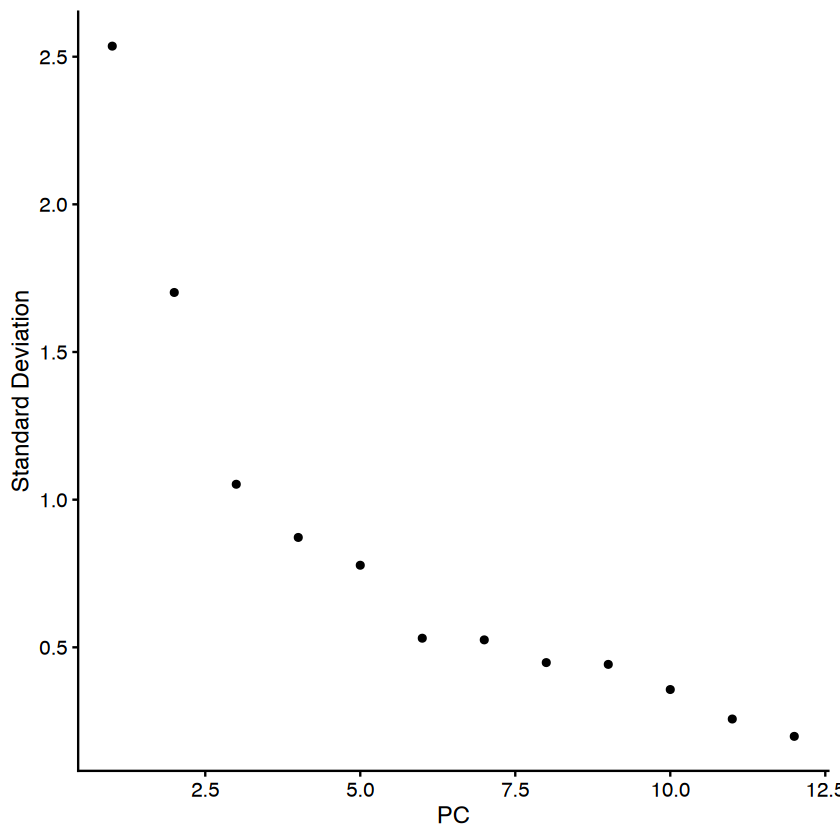

In [5]:
ElbowPlot(obj, ndims = 12, 
          reduction = "pca.sec"
         )

In [6]:
dims_use <- 1:9

# Build the SNN graph and run UMAP using your custom PCA reduction
obj <- FindNeighbors(obj, reduction = "pca.sec", dims = dims_use, verbose = FALSE)
obj <- RunUMAP(obj, reduction = "pca.sec", dims = dims_use, reduction.name = "umap", verbose = FALSE)

# Pick a grouping column to color by (change to what you have in obj@meta.data)
group_col <- intersect(c("Group"),
                       colnames(obj@meta.data))
group_col <- if (length(group_col)) group_col[1] else NULL

# Plot
p_umap <- DimPlot(obj, reduction = "umap",
                  group.by = group_col, label = TRUE, repel = TRUE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


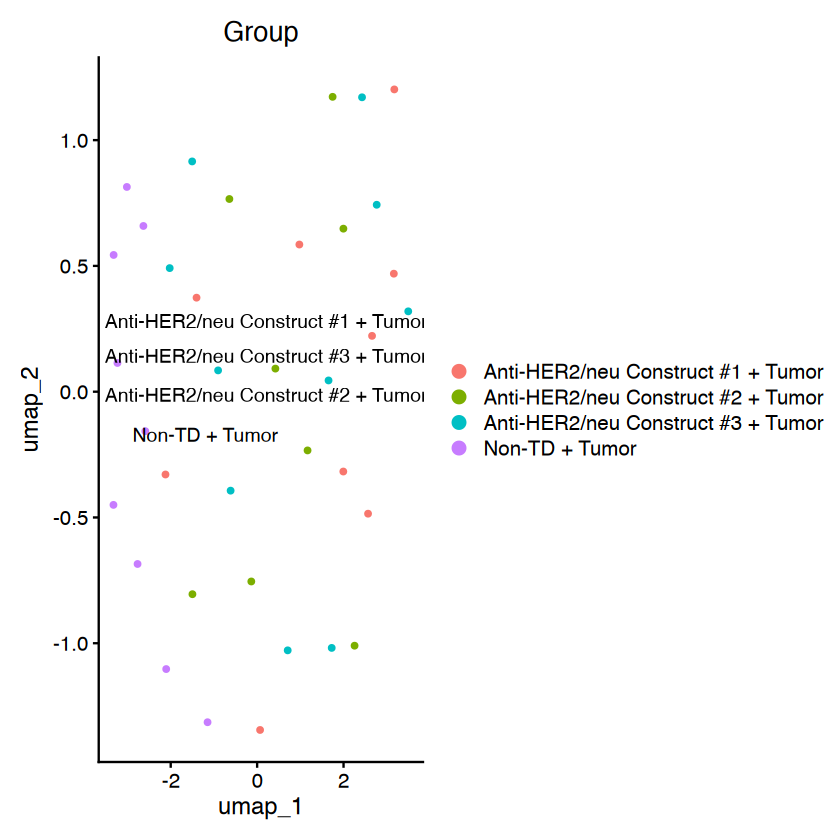

In [7]:
p_umap

In [8]:
# Split by biogroup

stopifnot(all(c("Sample","Group") %in% colnames(obj@meta.data)))

obj$Sample_Group <- paste(obj$Group,obj$Sample, sep = "_")

combo <- unique(obj@meta.data[, c("Group","Sample","Sample_Group")])
combo <- combo[order(combo$Group, combo$Sample), , drop = FALSE]
ordered_levels <- combo$Sample_Group

obj$Sample_Group <- factor(obj$Sample_Group,
                                           levels = ordered_levels)

In [9]:
rownames(obj[["Secretome"]])

[1] "IL-17A"     "IL-2"       "IL-4"       "IL-10"      "IL-6"      
 [6] "TNF-α"      "Fas"        "FasL"       "IFN-γ"      "Granzyme A"
[11] "Granzyme B" "Perforin"   "Granulysin"

In [15]:
cytokines = c('IL-6','IL-17A','IL-10','IFN-γ','TNF-α',
              'Granzyme B','IL-2','Perforin','IL-4','Fas','FasL','Granulysin','Granzyme A')

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'IFN-γ' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'IFN-γ' в 'mbcsToSbcs': точка заменена на <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <b1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'IFN-γ' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call.graphics(C_text, a

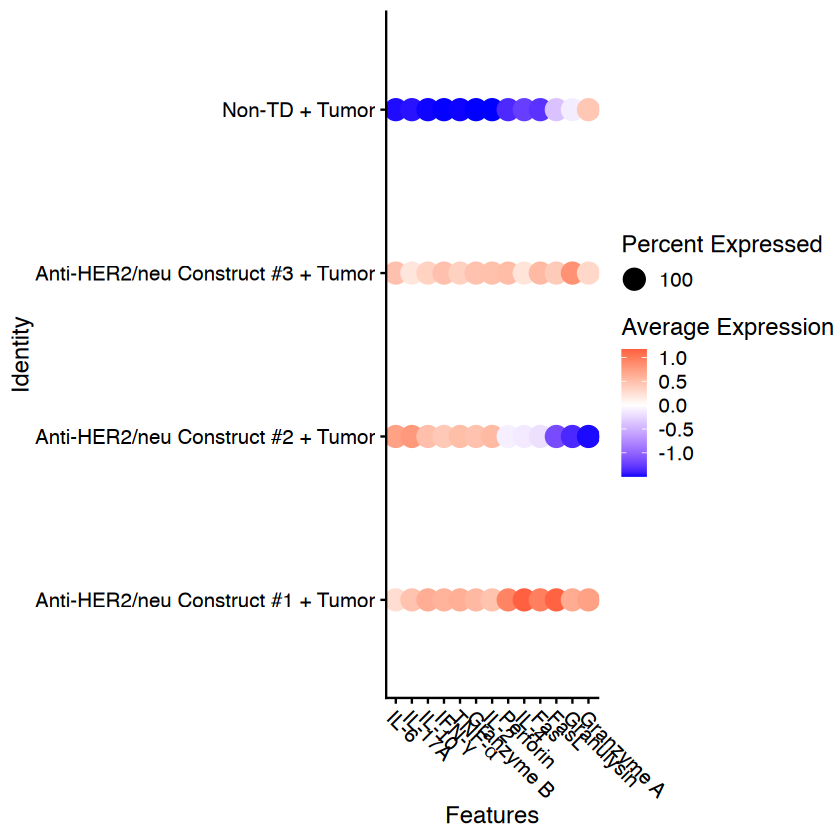

In [16]:
DefaultAssay(obj) <- "Secretome"
Idents(obj) <- "Group"   # or "Sample_Group"

p <- DotPlot(
  obj,
  features   = cytokines,
  dot.scale  = 11,                 # << increase this (e.g., 6–12) for larger dots
  scale.by   = "radius",           # default; keeps area perceptual
) + RotatedAxis() + scale_colour_gradient2(low = "blue", mid = "white", high = "red") + theme(axis.text.x = element_text(angle = -45, hjust = 0, vjust = 1)) # + theme(axis.text.x = element_text(angle = 90))+ coord_flip()

print(p)

ggsave(
  filename = "Dot Plot Secretome Samples.jpeg",
  plot     = p,
  width    = 30,
  height   = 8.5,
  units    = "cm",
  dpi      = 600,
  limitsize = TRUE,
  bg       = "white"
)

In [16]:
obj@meta.data

,orig.ident,nCount_Secretome,nFeature_Secretome,Group,Sample,Sample_Group
,<fct>,<dbl>,<int>,<chr>,<int>,<fct>
1,Secretome,21259.106,13,Anti-HER2/neu Construct #1 + Tumor,1,Anti-HER2/neu Construct #1 + Tumor_1
2,Secretome,10456.158,13,Anti-HER2/neu Construct #1 + Tumor,2,Anti-HER2/neu Construct #1 + Tumor_2
3,Secretome,78250.246,13,Anti-HER2/neu Construct #1 + Tumor,3,Anti-HER2/neu Construct #1 + Tumor_3
4,Secretome,28211.208,13,Anti-HER2/neu Construct #1 + Tumor,4,Anti-HER2/neu Construct #1 + Tumor_4
5,Secretome,15883.728,13,Anti-HER2/neu Construct #1 + Tumor,5,Anti-HER2/neu Construct #1 + Tumor_5
6,Secretome,26759.838,13,Anti-HER2/neu Construct #1 + Tumor,6,Anti-HER2/neu Construct #1 + Tumor_6
7,Secretome,35235.961,13,Anti-HER2/neu Construct #1 + Tumor,7,Anti-HER2/neu Construct #1 + Tumor_7
8,Secretome,15001.919,13,Anti-HER2/neu Construct #1 + Tumor,8,Anti-HER2/neu Construct #1 + Tumor_8
9,Secretome,55847.540,13,Anti-HER2/neu Construct #1 + Tumor,9,Anti-HER2/neu Construct #1 + Tumor_9


In [18]:
# Heatmap

assay_name <- "Secretome"
topN <- 100             
outfile <- "secretome_heatmap.jpeg"

DefaultAssay(obj) <- assay_name
mat <- tryCatch(
  GetAssayData(obj, assay = assay_name, layer = "data"),
  error = function(e) GetAssayData(obj, assay = assay_name, slot = "data")
)

meta_df <- obj@meta.data
stopifnot(all(c("Sample","Group") %in% colnames(meta_df)))
if (!"Sample_Group" %in% colnames(meta_df)) {
  # fallback: build it if missing (e.g., "S1_HER2-1")
  meta_df$Sample_Group <- paste0(meta_df$Sample, "_", meta_df$Group)
}

ann_col <- data.frame(
  Sample       = factor(meta_df$Sample, levels = sort(unique(meta_df$Sample))),
  Group        = factor(meta_df$Group),
  Sample_Group = as.character(meta_df$Sample_Group),   # free text for labels
  row.names = colnames(mat),
  check.names = FALSE
)

ord <- order(ann_col$Group, ann_col$Sample, na.last = TRUE)
mat      <- mat[, ord, drop = FALSE]
ann_col  <- ann_col[ord, , drop = FALSE]

col_labels <- ann_col$Sample_Group

if (is.infinite(topN) || topN >= nrow(mat)) {
  mat_sub <- mat
} else {
  v <- rowSds(as.matrix(mat))
  sel <- order(v, decreasing = TRUE)[seq_len(min(topN, nrow(mat)))]
  mat_sub <- mat[sel, , drop = FALSE]
}

mat_sub[!is.finite(mat_sub)] <- 0

mat_z <- t(scale(t(as.matrix(mat_sub))))
mat_z[!is.finite(mat_z)] <- 0
mat_z <- pmin(pmax(mat_z, -3), 3)


bwr_cols <- c("#313695","#4575B4","#74ADD1","#ABD9E9","#E0F3F8",
              "#FFFFFF",
              "#FEE090","#FDAE61","#F46D43","#D73027","#A50026")
col_fun <- circlize::colorRamp2(seq(-3, 3, length.out = length(bwr_cols)), bwr_cols)

grp_levels <- levels(ann_col$Group)
grp_cols   <- setNames(viridisLite::plasma(length(grp_levels)), grp_levels)

s_levels <- levels(ann_col$Sample)
smp_cols <- if ("package:Seurat" %in% search() && "DiscretePalette" %in% getNamespaceExports("Seurat")) {
  setNames(Seurat::DiscretePalette(length(s_levels)), s_levels)
} else {
  setNames(scales::hue_pal()(length(s_levels)), s_levels)
}

ha_top <- HeatmapAnnotation(
  Sample = ann_col$Sample,
  Group  = ann_col$Group,
  col = list(Sample = smp_cols, Group = grp_cols),
  annotation_name_side = "left",
  gap = unit(2, "mm")
)

In [29]:
# Plot and save

ht <- Heatmap(
  mat_z,
  name = "z",
  col = col_fun,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_row_names = TRUE,
  show_column_names = TRUE,
  column_labels = col_labels,    # <-- now shows Sample_Group
  top_annotation = ha_top, 
  column_split = ann_col$Group,
  cluster_column_slices = FALSE,
  use_raster = TRUE,
  raster_quality = 2,
  row_title = "Cytokines",
  column_title = "Samples",
  heatmap_legend_param = list(title = "Row z-score")
)

if (!requireNamespace("ragg", quietly = TRUE)) {
  install.packages("ragg", repos = "https://cloud.r-project.org")
}

width_in <- 19.5; height_in <- 8.5; dpi <- 600

ragg::agg_jpeg(outfile, width = width_in, height = height_in, units = "in", res = dpi)
draw(ht, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

message(sprintf("Saved heatmap to '%s' (%.1f x %.1f in @ %d dpi).",
                outfile, width_in, height_in, dpi))

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <b1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'IFN-γ' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'IFN-γ' в 'mbcsToSbcs': точка заменена на <b3>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка конвертации 'TNF-α' в 'mbcsToSbcs': точка заменена на <b1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“ошибка к

pdf 
  2

Saved heatmap to 'secretome_heatmap.jpeg' (19.5 x 8.5 in @ 600 dpi).



In [12]:
# DSC

Idents(obj) <- "Group"
DefaultAssay(obj) <- 'Secretome'

DSC <- FindMarkers(obj, ident.1 = "Anti-HER2/neu Construct #3 + Tumor", ident.2 = "Non-TD + Tumor",
             logfc.threshold = 0, test.use = "t")

DSC %>% 
  dplyr::filter(p_val_adj < 1) %>% 
  dplyr::arrange(desc(avg_log2FC)) %>% 
  tibble::rownames_to_column("gene") %>% 
  readr::write_csv("Pairwise_comp_results #3.csv")

DSC

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL-2,4.452944e-07,5.17186256,1,1,5.788827e-06
Granzyme B,6.965433e-06,4.81523279,1,1,9.055063e-05
Fas,9.557524e-04,2.11499802,1,1,1.242478e-02
IL-4,1.558884e-03,0.96046463,1,1,2.026550e-02
IFN-γ,2.359221e-03,3.68306275,1,1,3.066988e-02
TNF-α,3.315860e-03,1.95788886,1,1,4.310619e-02
IL-10,1.426011e-02,1.88194193,1,1,1.853814e-01
IL-17A,1.842059e-02,4.43752370,1,1,2.394676e-01
Perforin,1.336627e-01,1.86206303,1,1,1.000000e+00


In [ ]:
# Save object if needed 
saveRDS(obj, file = "secretomics.rds")

In [13]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Asia/Yerevan
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] future_1.40.0      matrixStats_1.5.0  viridisLite_0.4.2  pheatmap_1.0.12   
 [5] forcats_1.0.0      ggrepel_0.9.6      ggplot2_3.5.2      stringr_1.5.1     
 [9] dplyr_1.1.4        Matrix_1.6-4       Seurat_5.2.1       SeuratObject_5.1.0
[13] sp_2.2-0          

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.3        
  [4] spatstat.utils_3.1-4   farver_2.1.2           ragg_1.2.7            
  [7] vc